# Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

2024-11-22 15:12:08.972347: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 15:12:08.975692: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 15:12:08.983325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 15:12:08.996108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 15:12:08.999564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 15:12:09.011631: I tensorflow/core/platform/cpu_feature_gu

# Input data - dropping date and bitcoin opening, high and low prices

In [2]:
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

In [4]:
data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [5]:
data.shape

(2430, 48)

In [6]:
data.isna().sum()

Date                           0
BTC_Open                       0
BTC_High                       0
BTC_Low                        0
BTC_Close                      0
BTC_Volume                     0
Active Addr Cnt                0
Xfer Cnt                       0
Mean Tx Size (native units)    0
Total Fees (USD)               0
Mean Hash Rate                 0
Difficulty                     0
Mean Block Size (in bytes)     0
Sum Block Weight               0
LTC                            0
XRP                            0
DASH                           0
DOGE                           0
ETH                            0
Gold                           0
Silver                         0
Copper                         0
Oil                            0
Treasury Yield 10 Years        0
S&P500                         0
DJI                            0
CBOE                           0
NASDAQ                         0
JP225                          0
CSI300                         0
DXY       

# Split data into train and test set

In [7]:
start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] <= end_day_p2)].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)
train_dataset_p2 = train_dataset_p2.drop(columns = ["Date"])
test_dataset_p2 = test_dataset_p2.drop(columns = ["Date"])

In [8]:
# Define the target variable
target = 'BTC_Close'

# Create the feature sets
X_train = train_dataset_p2[:-1]
X_test = test_dataset_p2[:-1]

# Create the target sets
Y_train = train_dataset_p2[target][1:]
Y_test = test_dataset_p2[target][1:]

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (2246, 47)
X_test shape: (182, 47)
Y_train shape: (2246,)
Y_test shape: (182,)


# Normalize data with MinMaxScaler

In [9]:
# Normalize the datasets using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Update the variables used for training
X_train = X_train_scaled
X_test = X_test_scaled

print(len(X_train))

2246


# Model initialization & compilation

In [10]:
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal", kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal", kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal", kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error',
              metrics=['mae', 'mse'])

/home/hoangbaoan1901/Development/anaconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Fit train set with label using LSTM model, predict & visualization

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=50,restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, Y_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 301688032.0000 - mae: 10357.1484 - mse: 301688000.0000
Epoch 2/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168078112.0000 - mae: 7743.9873 - mse: 168078032.0000
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81942720.0000 - mae: 7016.1089 - mse: 81942632.0000
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41148712.0000 - mae: 4826.8389 - mse: 41148612.0000
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19506580.0000 - mae: 2399.9788 - mse: 19506482.0000
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13791726.0000 - mae: 2085.5200 - mse: 13791626.0000
Epoch 7/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11311448.0000 - mae: 1946.0931 - mse: 11311348.0000
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10577302.0000 - mae: 1858.9381 - mse: 10577198.0000
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9459508.0000 - mae: 1669.7651 - mse: 94

In [12]:
# Use the model to make predictions on the test set
predictions = model.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(Y_test, predictions)
print("R^2 score:", r2)
# RMSE
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(Y_test, predictions)
print("RMSE:", rmse)

# Directional Accuracy
def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

da = directional_accuracy(Y_test, predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R^2 score: 0.8868538077811139
RMSE: 2956.2157462310643


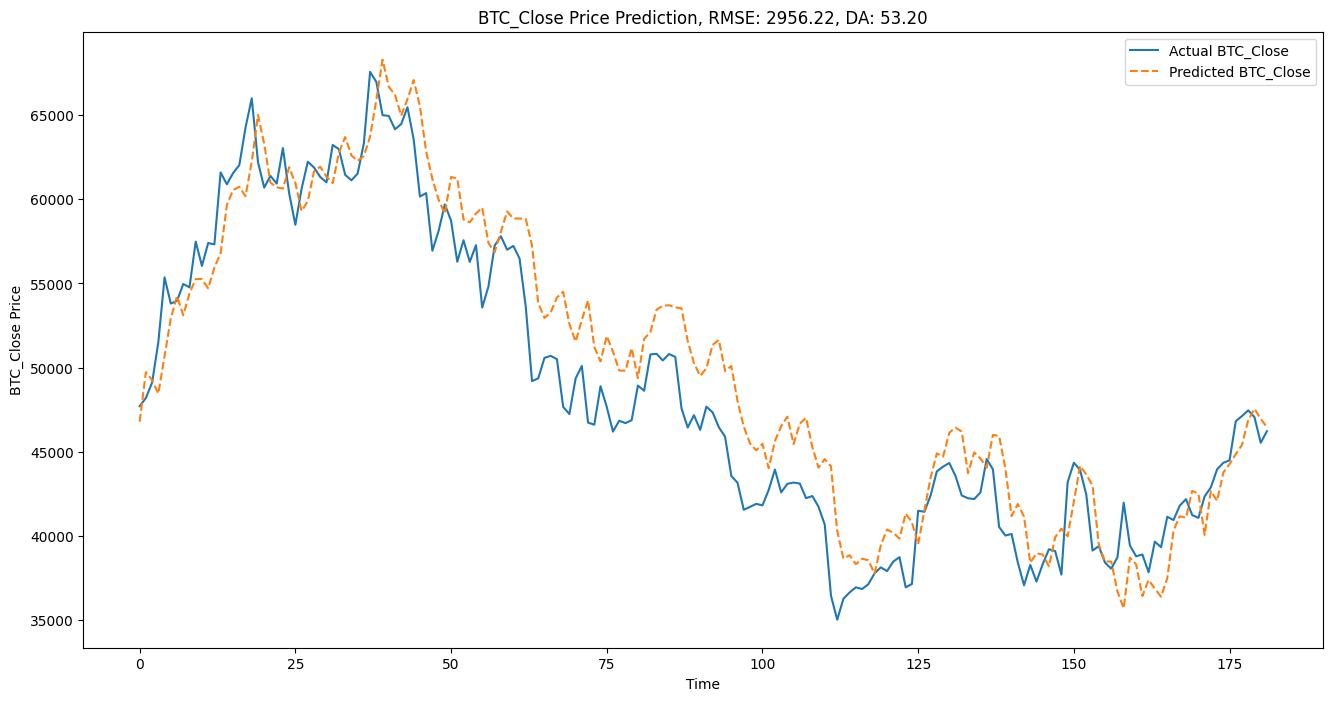

In [13]:
# Plot the predictions against the actual values
plt.figure(figsize=(16, 8))
plt.plot(Y_test, label='Actual BTC_Close')
plt.plot(predictions, label='Predicted BTC_Close', linestyle='dashed')
plt.title('BTC_Close Price Prediction, RMSE: {:.2f}, DA: {:.2f}'.format(rmse, da))
plt.xlabel('Time')
plt.ylabel('BTC_Close Price')
plt.legend()
plt.show()

In [14]:
# import pickle

# # Save the model
# pickle.dump(model, open('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/implementations/models/mlp_p2.pkl', 'wb'))